In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import backtrader.indicators as btind

from backtrader.feeds import GenericCSVData

In [2]:
class cot_csv(GenericCSVData):
    
    lines= ('CommNetyearpercent','CommNetfiveyearpercent', 'CommNetpercentOI')
    
    params = (
        ('dtformat', '%m/%d/%Y'),
        ('datetime', 0),
        ('time', -1),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 6),
        ('openinterest', -1),
        ('CommNetpercentOI', 33),
        ('CommNetyearpercent', 34),        
        ('CommNetfiveyearpercent', 36),
    )

In [3]:
class BuyAndHold_1(bt.Strategy):
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy all the available cash
        size = int(self.broker.get_cash() / self.data)
        self.buy(size=size)

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

In [4]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()    
    
    # Add a strategy
    cerebro.addstrategy(BuyAndHold_1)
    
    
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'C:\\Users\\big_u\\Backtrader COT Testing\COTTest6.csv')

    # Create a Data Feed
    data = cot_csv(
        dataname=datapath,
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=150)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    
    # Set the commission
    cerebro.broker.setcommission(commission=0.00)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


ROI:        1400.05%
Final Portfolio Value: 1500049.96


<IPython.core.display.Javascript object>


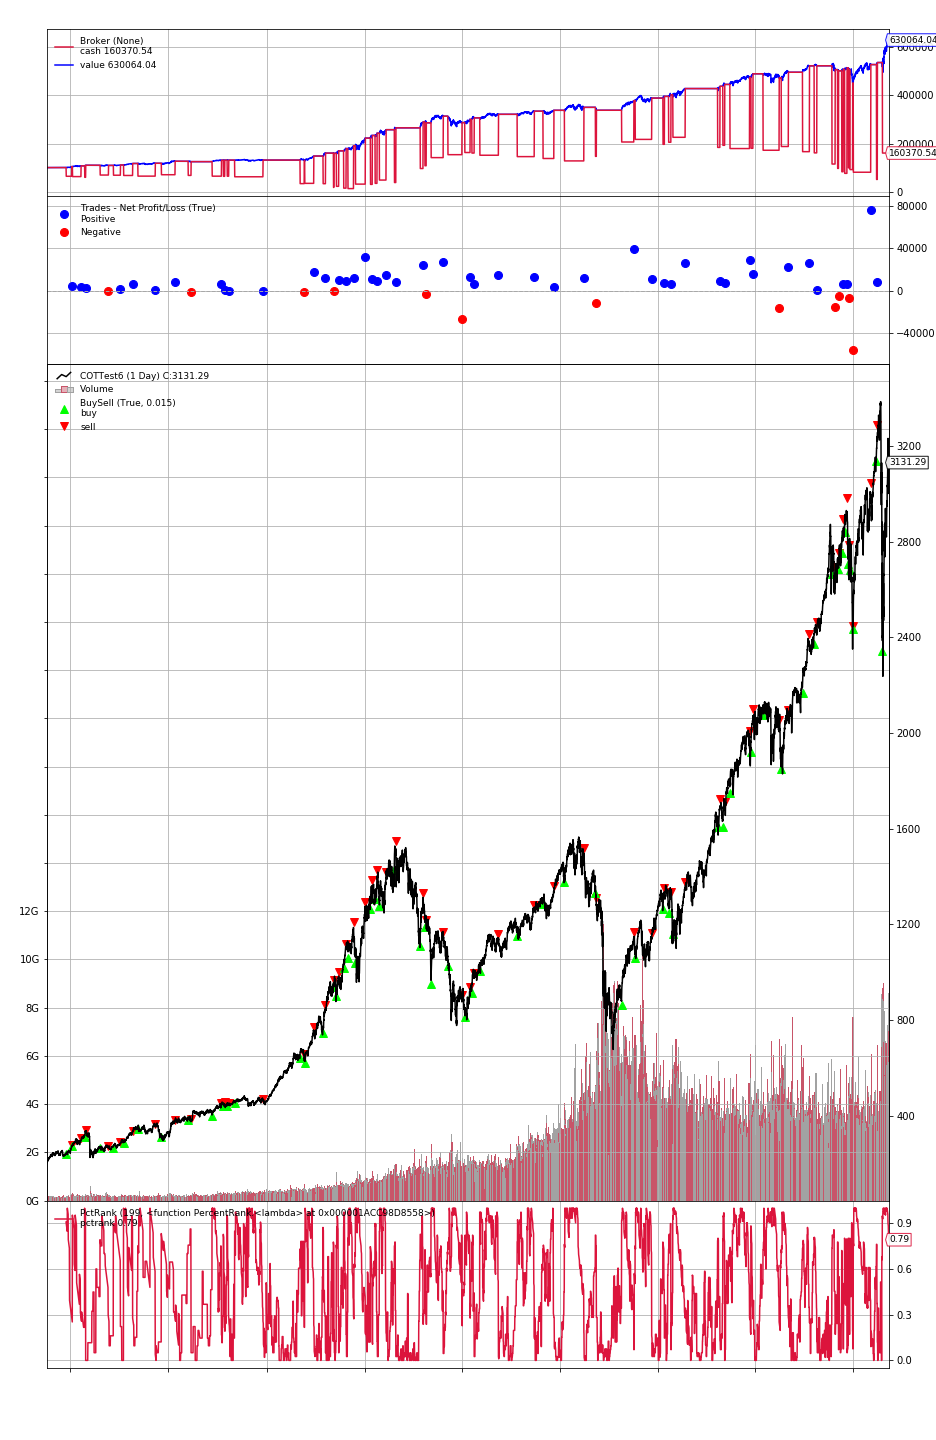

[[<Figure size 936x1440 with 5 Axes>]]

In [11]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 13, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
# Plot the result
cerebro.plot()

In [2]:
#Create a Strategy
class TestStrategy(bt.Strategy):
    params = (
        ('period', 199),
        ('threshold', 29),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function fot this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a PercentRank indicator
        self.pctrank = bt.indicators.PctRank(
            self.data.CommNetpercentOI, period=self.params.period)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # buy when commercials greater than rolling percentile 90%
            if self.pctrank >= (1 - (self.params.threshold)/100):
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                
        else:
            
            # sell when commercials less than rolling percentile 10%
            if self.pctrank <= (0 + (self.params.threshold)/100):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()
    def stop(self):
        self.log('(Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)

NameError: name 'bt' is not defined

In [1]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()    
    
    # Add a strategy
    cerebro.addstrategy(TestStrategy)
    
    
    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'C:\\Users\\big_u\\Backtrader COT Testing\COTTest6.csv')

    # Create a Data Feed
    data = cot_csv(
        dataname=datapath,
    )

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    startcash = 100000

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=150)

    # Print out the starting conditions
    #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()
    
    # Set the commission
    cerebro.broker.setcommission(commission=0.00)

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


NameError: name 'bt' is not defined

<IPython.core.display.Javascript object>


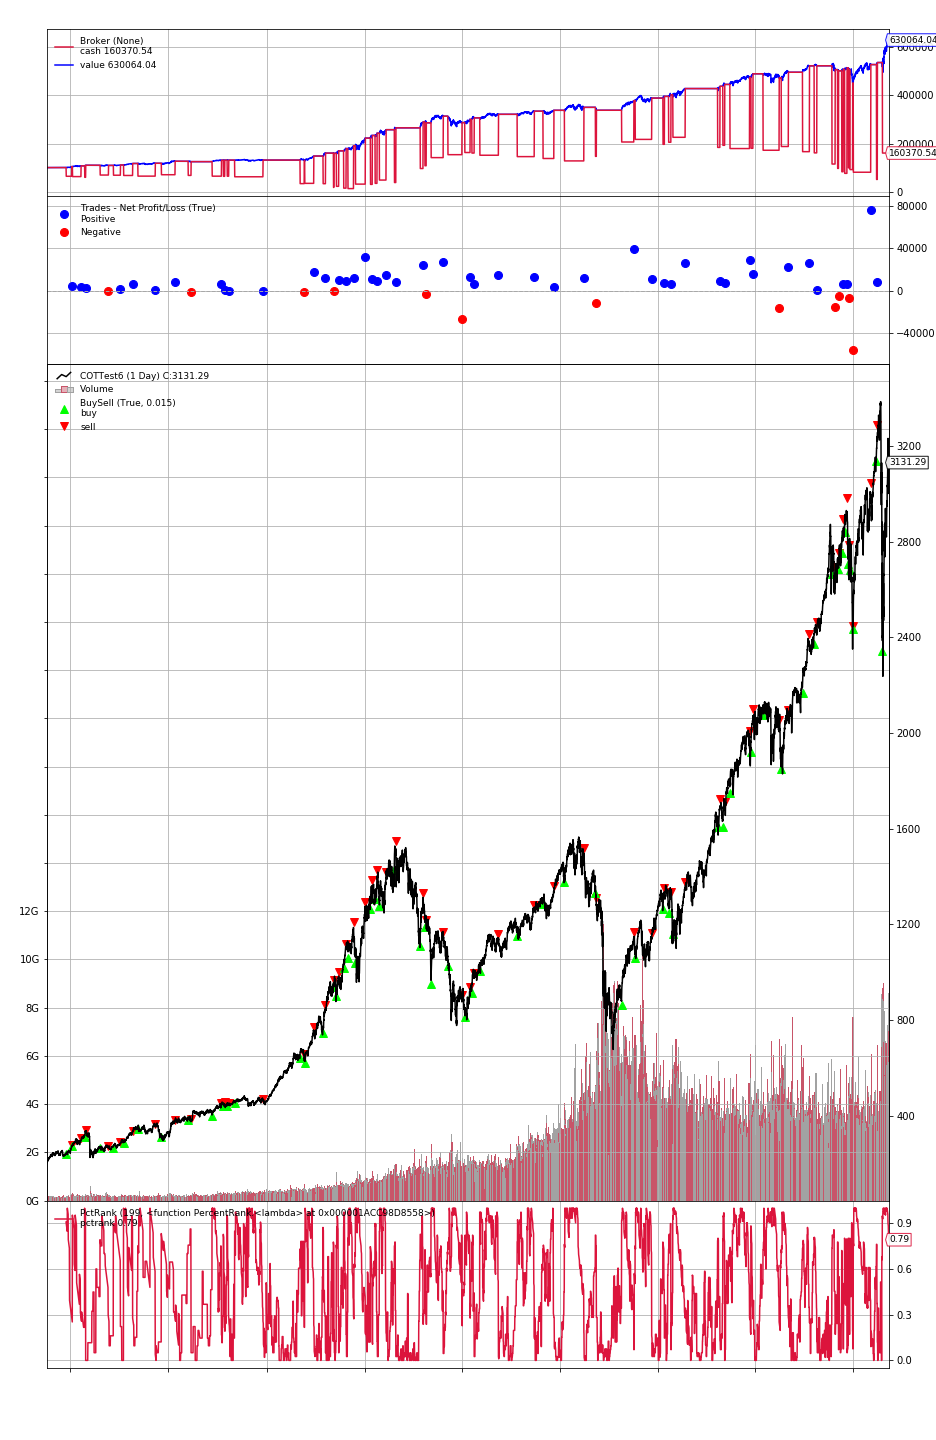

[[<Figure size 936x1440 with 5 Axes>]]

In [8]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 13, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
# Plot the result
cerebro.plot()

In [9]:
# ##OPTIMIZE PERCENTRANK THRESHOLD COMMERCIALS NET AS % OF OI

# from __future__ import (absolute_import, division, print_function,
#                         unicode_literals)

# import datetime  # For datetime objects
# import os.path  # To manage paths
# import sys  # To find out the script name (in argv[0])


# # Import the backtrader platform
# import backtrader as bt
# import backtrader.indicators as btind


# #Create a Strategy
# class TestStrategy(bt.Strategy):
#     params = (
#         ('period', 199),
#         ('threshold', 29),
#         ('printlog', False),
#     )

#     def log(self, txt, dt=None, doprint=False):
#         ''' Logging function fot this strategy'''
#         if self.params.printlog or doprint:
#             dt = dt or self.datas[0].datetime.date(0)
#             print('%s, %s' % (dt.isoformat(), txt))

#     def __init__(self):
#         # Keep a reference to the "close" line in the data[0] dataseries
#         self.dataclose = self.datas[0].close

#         # To keep track of pending orders and buy price/commission
#         self.order = None
#         self.buyprice = None
#         self.buycomm = None

#         # Add a PercentRank indicator
#         self.pctrank = bt.indicators.PctRank(
#             self.data.CommNetpercentOI, period=self.params.period)


#     def notify_order(self, order):
#         if order.status in [order.Submitted, order.Accepted]:
#             # Buy/Sell order submitted/accepted to/by broker - Nothing to do
#             return

#         # Check if an order has been completed
#         # Attention: broker could reject order if not enough cash
#         if order.status in [order.Completed]:
#             if order.isbuy():
#                 self.log(
#                     'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
#                     (order.executed.price,
#                      order.executed.value,
#                      order.executed.comm))

#                 self.buyprice = order.executed.price
#                 self.buycomm = order.executed.comm
#             else:  # Sell
#                 self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
#                          (order.executed.price,
#                           order.executed.value,
#                           order.executed.comm))

#             self.bar_executed = len(self)

#         elif order.status in [order.Canceled, order.Margin, order.Rejected]:
#             self.log('Order Canceled/Margin/Rejected')

#         # Write down: no pending order
#         self.order = None

#     def notify_trade(self, trade):
#         if not trade.isclosed:
#             return

#         self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
#                  (trade.pnl, trade.pnlcomm))

#     def next(self):
#         # Simply log the closing price of the series from the reference
#         self.log('Close, %.2f' % self.dataclose[0])

#         # Check if an order is pending ... if yes, we cannot send a 2nd one
#         if self.order:
#             return

#         # Check if we are in the market
#         if not self.position:

#             # buy when commercials greater than rolling percentile 90%
#             if self.pctrank >= (1 - (self.params.threshold)/100):
#                 self.log('BUY CREATE, %.2f' % self.dataclose[0])
#                 self.order = self.buy()

#         else:
            
#             # sell when commercials less than rolling percentile 10%
#             if self.pctrank <= (0 + (self.params.threshold)/100):
#                 # SELL, SELL, SELL!!! (with all possible default parameters)
#                 self.log('SELL CREATE, %.2f' % self.dataclose[0])

#                 # Keep track of the created order to avoid a 2nd order
#                 self.order = self.sell()

#     def stop(self):
#         self.log('(Threshold %2d) Ending Value %.2f' %
#                  (self.params.threshold, self.broker.getvalue()), doprint=True)


# if __name__ == '__main__':
#     # Create a cerebro entity
#     cerebro = bt.Cerebro()

#     # Add a strategy
#     strats = cerebro.optstrategy(
#         TestStrategy,
#         threshold=range(5,31)) 

#     # Datas are in a subfolder of the samples. Need to find where the script is
#     # because it could have been called from anywhere
#     modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
#     datapath = os.path.join(modpath, 'C:\\Users\\big_u\\Backtrader COT Testing\COTTest6.csv')

#     # Create a Data Feed
#     data = cot_csv(
#         dataname=datapath,
#     )


#     # Add the Data Feed to Cerebro
#     cerebro.adddata(data)

#     # Set our desired cash start
#     cerebro.broker.setcash(100000.0)

#     # Add a FixedSize sizer according to the stake
#     cerebro.addsizer(bt.sizers.FixedSize, stake=150)

#     # Set the commission
#     cerebro.broker.setcommission(commission=0.0)

#     # Run over everything
#     cerebro.run(maxcpus=1)

In [10]:
# ##OPTIMIZE PERCENTRANK PERIOD COMMERCIALS NET AS % OF OI

# from __future__ import (absolute_import, division, print_function,
#                         unicode_literals)

# import datetime  # For datetime objects
# import os.path  # To manage paths
# import sys  # To find out the script name (in argv[0])


# # Import the backtrader platform
# import backtrader as bt
# import backtrader.indicators as btind


# #Create a Strategy
# class TestStrategy(bt.Strategy):
#     params = (
#         ('period', 199),
#         ('threshold', 29),
#         ('printlog', False),
#     )

#     def log(self, txt, dt=None, doprint=False):
#         ''' Logging function fot this strategy'''
#         if self.params.printlog or doprint:
#             dt = dt or self.datas[0].datetime.date(0)
#             print('%s, %s' % (dt.isoformat(), txt))

#     def __init__(self):
#         # Keep a reference to the "close" line in the data[0] dataseries
#         self.dataclose = self.datas[0].close

#         # To keep track of pending orders and buy price/commission
#         self.order = None
#         self.buyprice = None
#         self.buycomm = None

#         # Add a PercentRank indicator
#         self.pctrank = bt.indicators.PctRank(
#             self.data.CommNetpercentOI, period=self.params.period)


#     def notify_order(self, order):
#         if order.status in [order.Submitted, order.Accepted]:
#             # Buy/Sell order submitted/accepted to/by broker - Nothing to do
#             return

#         # Check if an order has been completed
#         # Attention: broker could reject order if not enough cash
#         if order.status in [order.Completed]:
#             if order.isbuy():
#                 self.log(
#                     'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
#                     (order.executed.price,
#                      order.executed.value,
#                      order.executed.comm))

#                 self.buyprice = order.executed.price
#                 self.buycomm = order.executed.comm
#             else:  # Sell
#                 self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
#                          (order.executed.price,
#                           order.executed.value,
#                           order.executed.comm))

#             self.bar_executed = len(self)

#         elif order.status in [order.Canceled, order.Margin, order.Rejected]:
#             self.log('Order Canceled/Margin/Rejected')

#         # Write down: no pending order
#         self.order = None

#     def notify_trade(self, trade):
#         if not trade.isclosed:
#             return

#         self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
#                  (trade.pnl, trade.pnlcomm))

#     def next(self):
#         # Simply log the closing price of the series from the reference
#         self.log('Close, %.2f' % self.dataclose[0])

#         # Check if an order is pending ... if yes, we cannot send a 2nd one
#         if self.order:
#             return

#         # Check if we are in the market
#         if not self.position:

#             # buy when commercials greater than rolling percentile 90%
#             if self.pctrank >= (1 - (self.params.threshold)/100):
#                 self.log('BUY CREATE, %.2f' % self.dataclose[0])
#                 self.order = self.buy()

#         else:
            
#             # sell when commercials less than rolling percentile 10%
#             if self.pctrank <= (0 + (self.params.threshold)/100):
#                 # SELL, SELL, SELL!!! (with all possible default parameters)
#                 self.log('SELL CREATE, %.2f' % self.dataclose[0])

#                 # Keep track of the created order to avoid a 2nd order
#                 self.order = self.sell()

#     def stop(self):
#         self.log('(Period %2d) Ending Value %.2f' %
#                  (self.params.period, self.broker.getvalue()), doprint=True)


# if __name__ == '__main__':
#     # Create a cerebro entity
#     cerebro = bt.Cerebro()

#     # Add a strategy
#     strats = cerebro.optstrategy(
#         TestStrategy,
#         period=range(50,600)) 

#     # Datas are in a subfolder of the samples. Need to find where the script is
#     # because it could have been called from anywhere
#     modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
#     datapath = os.path.join(modpath, 'C:\\Users\\big_u\\Backtrader COT Testing\COTTest6.csv')

#     # Create a Data Feed
#     data = cot_csv(
#         dataname=datapath,
#     )


#     # Add the Data Feed to Cerebro
#     cerebro.adddata(data)

#     # Set our desired cash start
#     cerebro.broker.setcash(100000.0)

#     # Add a FixedSize sizer according to the stake
#     cerebro.addsizer(bt.sizers.FixedSize, stake=150)

#     # Set the commission
#     cerebro.broker.setcommission(commission=0.0)

#     # Run over everything
#     cerebro.run(maxcpus=1)